<a href="https://colab.research.google.com/github/GiovanniPioDelvecchio/NLP-Project/blob/main/Dataset%20statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# installation of the required libraries
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 74.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
# Cell for the download of the datasets
!wget https://zenodo.org/record/7550385/files/arguments-training.tsv
!wget https://zenodo.org/record/7550385/files/labels-training.tsv
!wget https://zenodo.org/record/7550385/files/arguments-validation.tsv
!wget https://zenodo.org/record/7550385/files/labels-validation.tsv
!wget https://zenodo.org/record/7550385/files/arguments-test.tsv
!wget https://zenodo.org/record/7550385/files/arguments-validation-zhihu.tsv
!wget https://zenodo.org/record/7550385/files/labels-validation-zhihu.tsv

--2023-02-10 11:29:26--  https://zenodo.org/record/7550385/files/arguments-training.tsv
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1012498 (989K) [application/octet-stream]
Saving to: ‘arguments-training.tsv’

arguments-training. 100%[===================>] 988.77K   481KB/s    in 2.1s    

2023-02-10 11:29:30 (481 KB/s) - ‘arguments-training.tsv’ saved [1012498/1012498]

--2023-02-10 11:29:30--  https://zenodo.org/record/7550385/files/labels-training.tsv
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253843 (248K) [application/octet-stream]
Saving to: ‘labels-training.tsv’

labels-training.tsv 100%[===================>] 247.89K   512KB/s    in 0.5s    

2023-02-10 11:29:32 (512 KB/s) - ‘labels-training.tsv’ saved [253843/2

In [3]:
# Imports for dataset loading
import pandas as pd
import numpy as np

# Imports for display or plot data
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from prettytable import PrettyTable

# Imports for tokenizers
from transformers import BertTokenizer
from torchtext.data import get_tokenizer

In [4]:
def fix_random(seed: int) -> None:
  """Fix all the possible sources of randomness.

  Params:
    seed: the seed to use. 
  """
  np.random.seed(seed)

In [5]:
# Cell needed to fix the seeds
seed = 10
fix_random(seed)

# Dataset Load and Splits

In [6]:
def train_test_split_wrt_conclusions(train, ratio=0.8):
  """
  Function needed to perform the splits over the original train dataset,
  in order to obtain a train and a validation set which are divided by unique
  conclusions. The ratio parameter is needed in order to assign which portion 
  of the unique conclusions must be selected for the train split.
  
  Params:
    train: the original train set, to be splitted (Pandas dataframe)
    ratio: the proportion in (0, 1) of unique conclusions to be inserted in 
           the training dataframe.
  Returns:
    train_set_to_return: the portion of train that contains ratio unique
                         conclusions.
    val_set_to_return: the proportion of the train that contains 1 - ratio
                       unique conclusions (the remaining ones)
  """
  val = []
  unique_conc = pd.unique(train["Conclusion"])
  num_train_con = int(len(unique_conc)*ratio)
  train_unique_conc = np.random.choice(unique_conc, num_train_con, replace = False)
  val_unique_conc = set(unique_conc) - set(train_unique_conc)
  train_set_to_return = train[train.Conclusion.isin(train_unique_conc)] 
  val_set_to_return = train[train.Conclusion.isin(val_unique_conc)]
  return train_set_to_return, val_set_to_return

In [7]:
# Dataset loading and splitting
raw_training = pd.read_csv("arguments-training.tsv", encoding='utf-8', sep='\t', header=0)
raw_training_lab = pd.read_csv("labels-training.tsv", encoding='utf-8', sep='\t', header=0)
raw_test = pd.read_csv("arguments-validation.tsv", encoding='utf-8', sep='\t', header=0)
raw_test_lab = pd.read_csv("labels-validation.tsv", encoding='utf-8', sep='\t', header=0)
raw_test_chn = pd.read_csv("arguments-validation-zhihu.tsv", encoding='utf-8', sep='\t', header=0)
raw_test_chn_lab = pd.read_csv("labels-validation-zhihu.tsv", encoding='utf-8', sep='\t', header=0)

train = raw_training.join(raw_training_lab,how='inner' ,lsuffix='2') # joining labels
test = raw_test.join(raw_test_lab, how='inner', lsuffix='2') # joining labels
test_chn = raw_test_chn.join(raw_test_chn_lab, how='inner', lsuffix='2') # joining labels
fix_random(seed)
train, val = train_test_split_wrt_conclusions(train) # splitting training

# Get the list of label from the train dataset
label_list = [col for col in train.columns.values if col not in ['Conclusion', 'Stance', 'Premise', 'labels', 'Argument ID', 'Argument ID2']]

# Counts Labels on Datasets

In [8]:
def get_counts(df, label_list):
  """
    Function that given a dataframe and a list of labels, returns a dataframe
    where its rows are the labels from the list, with one column that is the
    count of the corresponding label in the dataframe given in input.

    Params:
      df: dataframe in which the labels are counted
      label_list: list of labels present in the dataframe df (in order)

    Returns:
      df_counts: dataframe with rows for labels and one column for counts

  """
  df_counts = pd.DataFrame()
  for label in label_list:
    to_add = df.groupby(label)[label].count()
    try:
      df_counts = df_counts.append({"Attribute Name": label, "Count": to_add[1]}, ignore_index=True)
    except KeyError:
      df_counts = df_counts.append({"Attribute Name": label, "Count": 0}, ignore_index=True)
  return df_counts

def display_correlation_labels(df, label_list):
  """
    Function used for display the correlation between labels, it creates a
    matrix where in the coordinate (i-th, j-th) it has the number of samples
    in the dataframe df with the label i-th and j-th.

    Params:
      df: dataframe from which to count the correlation between labels
      label_list: list of labels present in the dataframe df (in order)
    
    Returns:
      A display of the correlation matrix between labels
  """
  df_counts = pd.DataFrame(columns=["Attribute"] + label_list)
  for label in label_list:
    _dict = {"Attribute": label}
    _dict.update({k:0.0 for k in label_list})
    df_counts = df_counts.append(_dict, ignore_index=True)

  for couple in list(itertools.combinations(label_list, 2)):
    to_add = df.groupby(list(couple)).size()
    try:
      df_counts.loc[df_counts["Attribute"] == couple[0], couple[1]] = float(to_add[1, 1])
      df_counts.loc[df_counts["Attribute"] == couple[1], couple[0]] = 0.0
    except KeyError:
      df_counts.loc[df_counts["Attribute"] == couple[0], couple[1]] = 0.0
      df_counts.loc[df_counts["Attribute"] == couple[1], couple[0]] = 0.0
  
  df_counts = df_counts.set_index("Attribute")
  return df_counts.style \
    .background_gradient(cmap='YlOrRd', axis=None) \
    .set_table_styles([{'selector': 'th', 'props': [('font-size', '8pt'), ('text-align', 'center')]}]) \
    .set_properties(**{'font-size': '10pt', 'width': '10pt', 'height': '10pt', 'text-align': 'center'}) \
    .format(precision=0)

In [9]:
# In this cell, I count the labels in each dataframe (train, val,...) and then 
# combine the results of each count in a single dataframe called df_join_counts. 
df_counts_train = get_counts(train, label_list) 
df_counts_val = get_counts(val, label_list)
df_counts_test = get_counts(test, label_list)
df_counts_test_chn = get_counts(test_chn, label_list)

df_join_counts = df_counts_train.set_index("Attribute Name").join(df_counts_val.set_index("Attribute Name"), lsuffix="_train", rsuffix="_val")
df_join_counts = df_join_counts.join(df_counts_test.set_index("Attribute Name").rename(columns={"Count": "Count_test"}), lsuffix="_test", rsuffix="_test")
df_join_counts = df_join_counts.join(df_counts_test_chn.set_index("Attribute Name").rename(columns={"Count": "Count_test_chnn"}), lsuffix="_test", rsuffix="_test")

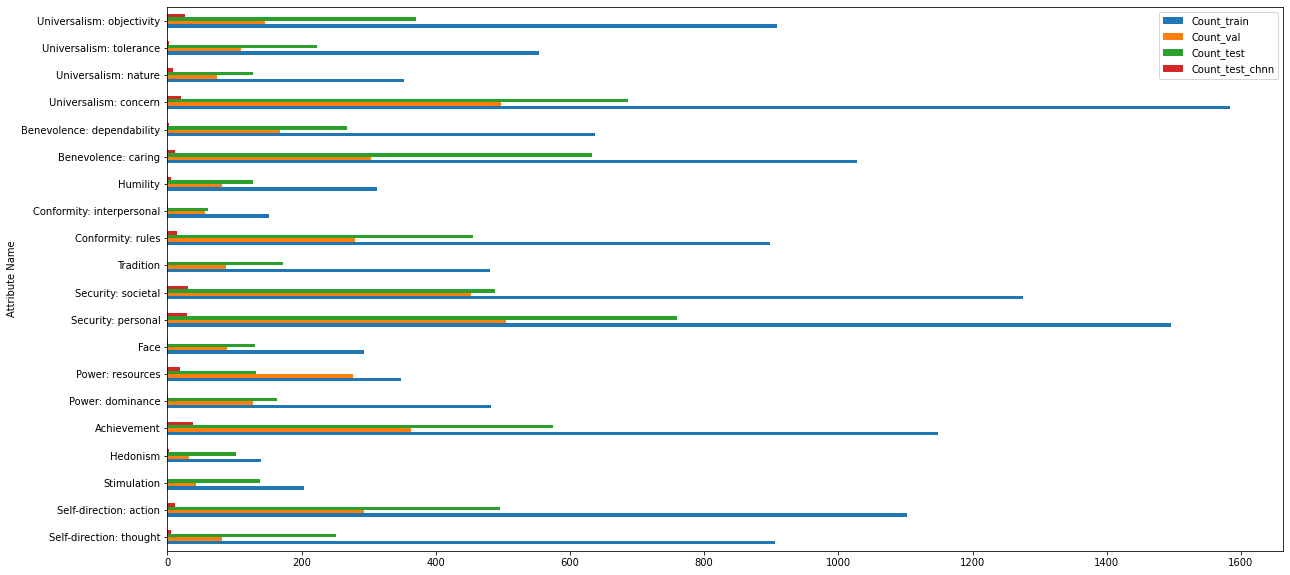

In [10]:
# Plotting the only one dataframe with the counts for every label and dataset
df_join_counts.plot(kind='barh', figsize=(20, 10));

# Correlation Matrix For Labels

In [11]:
# Display of the correlation matrix between labels in the train set
display_correlation_labels(train, label_list)

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Attribute,,,,,,,,,,,,,,,,,,,,
Self-direction: thought,0,470,77,37,354,79,60,70,217,118,158,103,19,32,178,64,228,32,192,252
Self-direction: action,0,0,100,79,257,127,85,89,320,196,203,143,45,54,210,106,336,40,190,228
Stimulation,0,0,0,51,90,13,16,33,87,27,17,16,5,10,50,17,46,22,52,28
Hedonism,0,0,0,0,35,2,9,20,81,9,11,5,2,10,43,7,20,16,25,15
Achievement,0,0,0,0,0,148,169,102,439,285,70,140,27,65,324,183,340,61,151,303
Power: dominance,0,0,0,0,0,0,28,56,94,247,43,127,9,19,105,89,227,6,62,108
Power: resources,0,0,0,0,0,0,0,30,173,82,20,37,8,20,77,53,122,19,14,64
Face,0,0,0,0,0,0,0,0,106,71,32,67,22,19,80,37,115,14,70,64
Security: personal,0,0,0,0,0,0,0,0,0,398,110,254,52,137,450,242,491,94,212,260


In [12]:
# Display of the correlation matrix between labels in the validation set
display_correlation_labels(val, label_list)

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Attribute,,,,,,,,,,,,,,,,,,,,
Self-direction: thought,0,58,13,7,20,9,13,8,25,6,6,11,1,4,19,1,23,1,21,12
Self-direction: action,0,0,25,19,75,33,51,21,116,50,13,48,27,16,83,23,90,6,50,38
Stimulation,0,0,0,7,19,1,17,4,22,7,0,1,0,2,15,3,13,1,11,4
Hedonism,0,0,0,0,10,1,7,3,21,6,0,3,3,3,7,1,14,0,13,3
Achievement,0,0,0,0,0,60,162,32,148,102,10,33,5,9,96,44,97,9,23,62
Power: dominance,0,0,0,0,0,0,34,15,42,53,4,23,1,5,27,18,48,4,16,17
Power: resources,0,0,0,0,0,0,0,14,146,78,6,24,2,7,57,36,76,2,12,33
Face,0,0,0,0,0,0,0,0,41,19,8,21,7,8,19,10,46,1,28,7
Security: personal,0,0,0,0,0,0,0,0,0,166,21,83,20,24,162,70,183,23,62,47


In [13]:
# Display of the correlation matrix between labels in the test set
display_correlation_labels(test, label_list)

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Attribute,,,,,,,,,,,,,,,,,,,,
Self-direction: thought,0,137,41,37,93,22,3,14,58,25,22,41,8,13,59,14,40,12,56,53
Self-direction: action,0,0,55,42,132,56,40,28,181,67,45,70,14,34,170,47,136,26,84,85
Stimulation,0,0,0,47,53,13,4,16,66,17,9,20,4,9,51,15,24,4,34,10
Hedonism,0,0,0,0,25,5,0,10,50,8,7,10,4,11,36,6,11,8,18,15
Achievement,0,0,0,0,0,69,57,44,205,122,30,103,6,30,168,92,170,30,77,140
Power: dominance,0,0,0,0,0,0,6,18,46,76,14,41,5,7,43,35,64,8,22,32
Power: resources,0,0,0,0,0,0,0,2,99,23,1,13,0,6,34,26,50,4,5,16
Face,0,0,0,0,0,0,0,0,63,27,9,33,11,15,46,24,39,4,24,20
Security: personal,0,0,0,0,0,0,0,0,0,138,51,119,20,49,319,124,212,47,91,103


In [14]:
# Display of the correlation matrix between labels in the test set chinese
display_correlation_labels(test_chn, label_list)

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Attribute,,,,,,,,,,,,,,,,,,,,
Self-direction: thought,0,0,0,0,5,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2
Self-direction: action,0,0,0,0,0,0,0,0,1,3,0,3,0,1,3,0,2,0,0,0
Stimulation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Hedonism,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
Achievement,0,0,0,0,0,0,11,0,14,9,0,4,1,1,5,2,3,0,0,11
Power: dominance,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
Power: resources,0,0,0,0,0,0,0,0,4,8,0,0,0,0,0,0,0,1,0,3
Face,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Security: personal,0,0,0,0,0,0,0,0,0,13,0,3,1,1,4,1,9,1,1,8


In [15]:
# Download of tokenizers, used after for getting the lengths of tokenized sentences
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
basic_tokenizer = get_tokenizer("basic_english")

# Lengths of Tokenized Data

In [16]:
def ordered_counts_dictionary(l):
  """
    This is a function that returns the counts of the elements in a list.
    The keys are the unique elements of the list and the values are the counts
    in the list for every elements of the list.

    Params:
      l: list from which create the dictionary of elements
    
    Returns:
      counts: dictionary with counts for every element in the list l, ordered
              by keys
  """
  list_elements = list(set(l))
  list_elements.sort()
  counts = {element: 0 for element in list_elements}
  for element in l:
    counts[element] = counts[element] + 1
  return counts

def display_dataset_tokenized(df, tokenizer, title):
  """
    Function used for display some data on a datased passed by input, it uses
    a tokenizer for tokenize the premises and conclusions of the df, and
    print/plot some data of the latter.

    Params:
      df: dataframe for which some data is displayed
      tokenizer: tokenizer used for tokenize the premises and conclusion in df
      title: title of the final plot (to distinguish different dataframes)
  """
  tokens = {"Premise": [], "Conclusion": []}
  columns = ["Premise", "Conclusion"]
  for index, row in df.iterrows():
    for column in columns:
      _tokenized = tokenizer(row[column])
      tokens[column].append(_tokenized["input_ids"] if "input_ids" in _tokenized else _tokenized)
  tokens_lengths = {}
  tokens_sets = {}
  table = PrettyTable(['Column', 'N. Unique Tokens', 'Mean Lengths', 'Min Tokens', 'Max Tokens', '90° Percentile'])

  for column in columns:
    tokens_lengths[column] = [len(sentence) for sentence in tokens[column]]
    tokens_sets[column] = set([token for sentence in tokens[column] for token in sentence])
    table.add_row([column, 
      len(tokens_sets[column]),
      str(round(np.mean(tokens_lengths[column]), 2)),
      np.min(tokens_lengths[column]),
      np.max(tokens_lengths[column]),
      str(round(np.quantile(tokens_lengths[column], 0.90), 2))
      ])

  print(table)
  fig, axs = plt.subplots(ncols=2, figsize=(25, 10))
  fig.suptitle(title)
  for idx, column in enumerate(columns):
    axs[idx].set_title('Lengths tokenized column ' + column)
    axs[idx].set_xlabel('Length')
    axs[idx].set_ylabel("Counts of row with same " + column + " length")
    counts_lengths = ordered_counts_dictionary(tokens_lengths[column])
    axs[idx].bar(list(counts_lengths.keys()), list(counts_lengths.values()));

+------------+------------------+--------------+------------+------------+----------------+
|   Column   | N. Unique Tokens | Mean Lengths | Min Tokens | Max Tokens | 90° Percentile |
+------------+------------------+--------------+------------+------------+----------------+
|  Premise   |       7157       |    23.74     |     4      |    148     |      38.0      |
| Conclusion |       853        |     6.66     |     4      |     35     |      10.0      |
+------------+------------------+--------------+------------+------------+----------------+


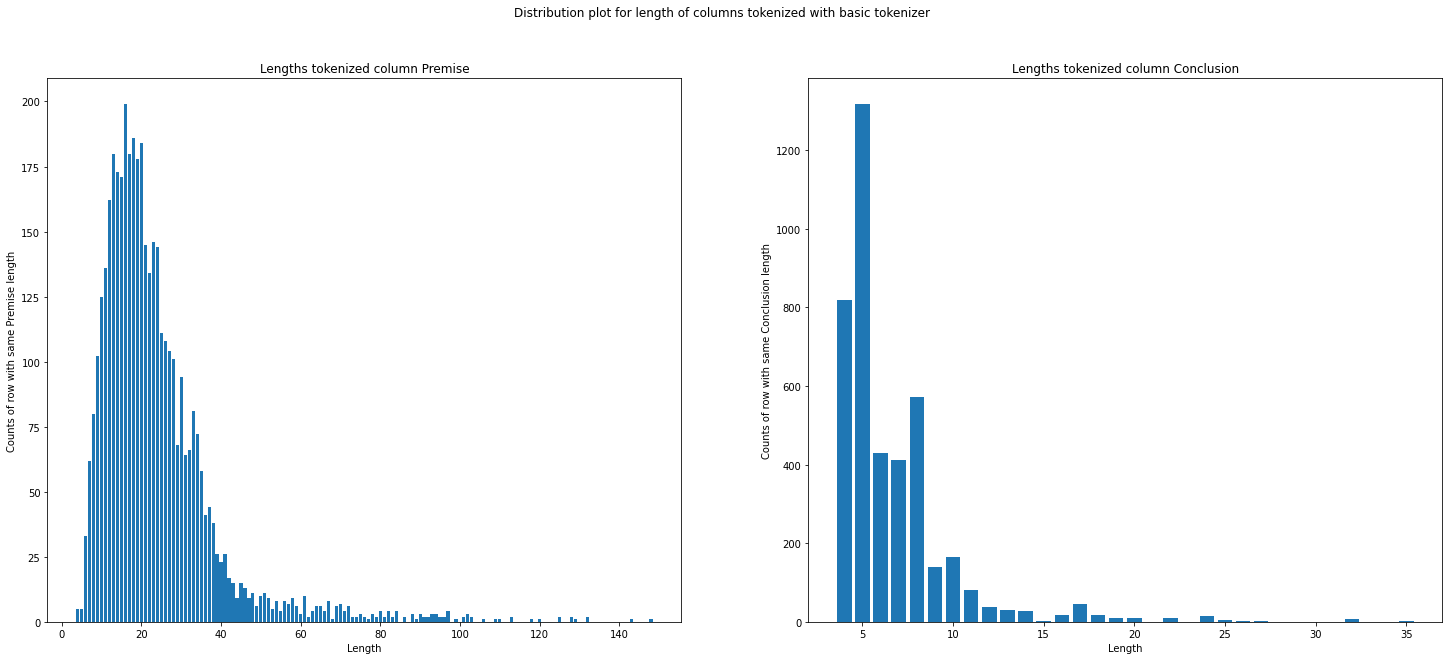

In [17]:
# Display of some data for the train dataset using the basic tokenizer
display_dataset_tokenized(train, basic_tokenizer, "Distribution plot for length of columns tokenized with basic tokenizer")

+------------+------------------+--------------+------------+------------+----------------+
|   Column   | N. Unique Tokens | Mean Lengths | Min Tokens | Max Tokens | 90° Percentile |
+------------+------------------+--------------+------------+------------+----------------+
|  Premise   |       6927       |    27.27     |     6      |    159     |      42.0      |
| Conclusion |       951        |     9.9      |     6      |     38     |      13.0      |
+------------+------------------+--------------+------------+------------+----------------+


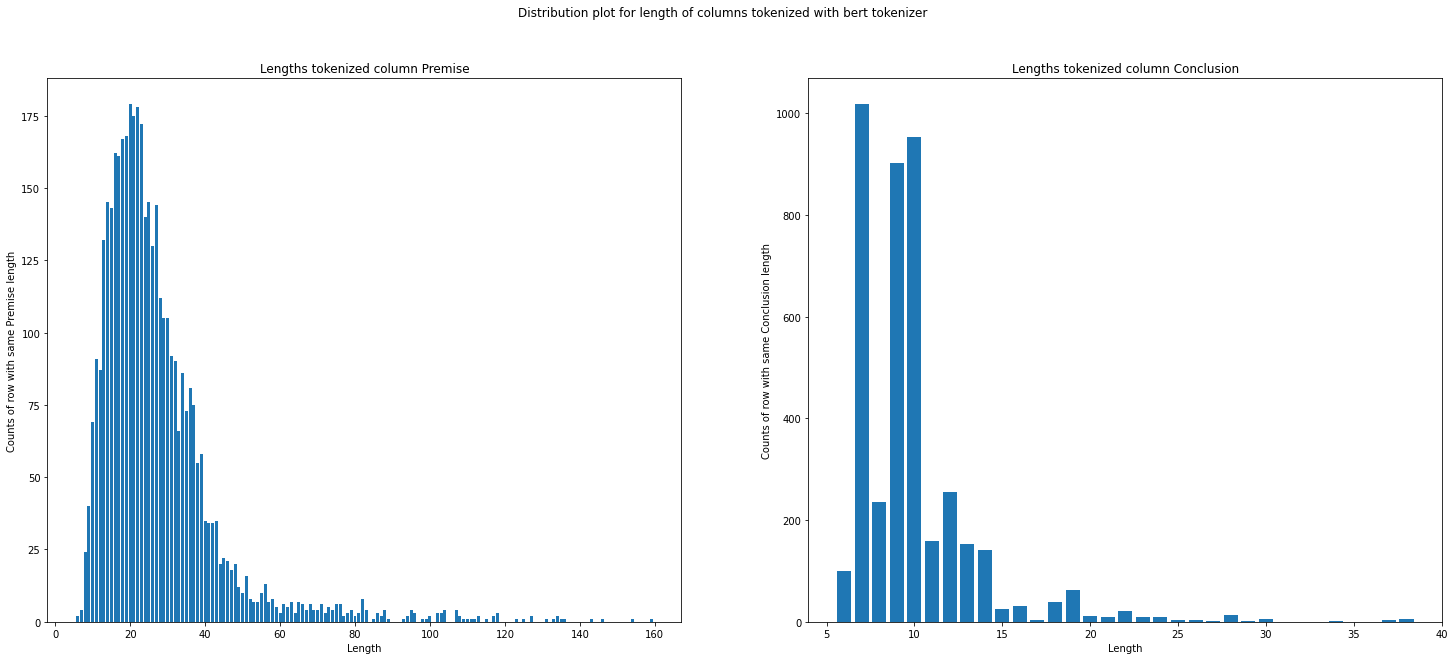

In [18]:
# Display of some data for the train dataset using the bert tokenizer
display_dataset_tokenized(train, bert_tokenizer, "Distribution plot for length of columns tokenized with bert tokenizer")

# Unique Conclusions in Datasets

In [19]:
print("Number of unique conclusions in train set        | Rows in train set        : " + str(len(train["Conclusion"].unique())) + " | " + str(train.shape[0]))
print("Number of unique conclusions in val set          | Rows in val set          : " + str(len(val["Conclusion"].unique())) + "  | " + str(val.shape[0]))
print("Number of unique conclusions in test set         | Rows in test set         : " + str(len(test["Conclusion"].unique())) + " | " + str(test.shape[0]))
print("Number of unique conclusions in chinese test set | Rows in chinese test set : " + str(len(test_chn["Conclusion"].unique())) + "  | " + str(test_chn.shape[0]))

Number of unique conclusions in train set        | Rows in train set        : 265 | 4176
Number of unique conclusions in val set          | Rows in val set          : 67  | 1217
Number of unique conclusions in test set         | Rows in test set         : 157 | 1896
Number of unique conclusions in chinese test set | Rows in chinese test set : 12  | 100
